In [0]:
# uncomment in case of google colab
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# uncomment in case of google colab
# import os
# PATH_TO_FILE = '/content/drive/My Drive/Development/fashion_instance_segmentation/src'
# os.chdir(PATH_TO_FILE)

In [0]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

MRNN_DIR = os.path.join(ROOT_DIR, 'externals/mask_rcnn')
#print(MRNN_DIR)
sys.path.append(MRNN_DIR)

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import rle_helper
import dress
#from src import dress

%matplotlib inline 

/content/drive/My Drive/Development/fashion_instance_segmentation/externals/mask_rcnn


In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
DRESS_DIR = os.path.join(ROOT_DIR, "data")

configResnet101 = dress.DressConfig()
configResnet50 = dress.DressResnet50Config()

In [0]:
configResnet101.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
configResnet50.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [0]:
dataset_train = dress.DressDataset()
dataset_train.load_dress(DRESS_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = dress.DressDataset()
dataset_val.load_dress(DRESS_DIR, "val")
dataset_val.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 10
Class Count: 2
  0. BG                                                
  1. dress                                             


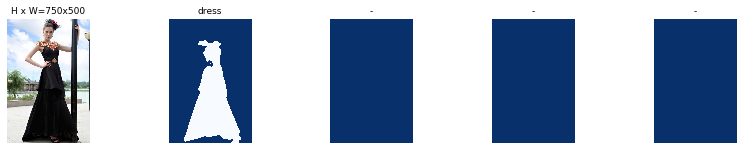

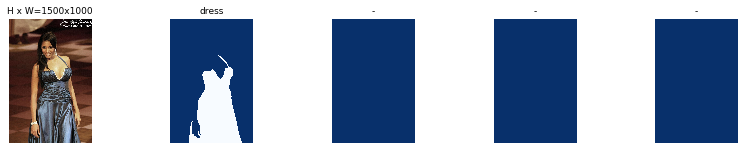

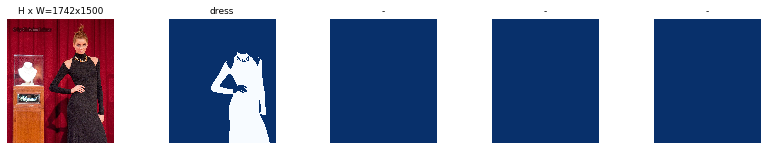

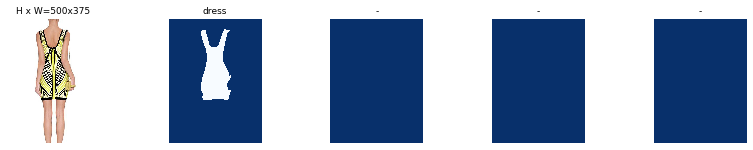

In [0]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [0]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [0]:
# Create model in training mode
modelResnet101 = modellib.MaskRCNN(mode="training", config=configResnet101,
                          model_dir=MODEL_DIR)

# Create model in training mode
modelResnet50 = modellib.MaskRCNN(mode="training", config=configResnet50,
                          model_dir=MODEL_DIR)

In [0]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MRNN_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

modelResnet101.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])


modelResnet50.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [0]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
modelResnet50.train(dataset_train, dataset_val, 
            learning_rate=configResnet50.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/Development/fashion_instance_segmentation/logs/dress20191116T1805/mask_rcnn_dress_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mas

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
100/100 [==============================] - 160s 2s/step - loss: 1.1563 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.2472 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.4137 - val_loss: 1.6590 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.5756 - val_mrcnn_class_loss: 0.0427 - val_mrcnn_bbox_loss: 0.7275 - val_mrcnn_mask_loss: 0.3041

Epoch 2/10
100/100 [==============================] - 71s 710ms/step - loss: 0.5148 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.1676 - val_loss: 1.7302 - val_rpn_class_loss: 0.0075 - val_rpn_bbox_loss: 0.6788 - val_mrcnn_class_loss: 0.0388 - val_mrcnn_bbox_loss: 0.5890 - val_mrcnn_mask_loss: 0.4160
Epoch 3/10
100/100 [==============================] - 74s 745ms/step - loss: 0.3252 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.1117 - val_loss: 1.8146 - val_rpn_

In [0]:
inference_config = dress.InferenceResnet50Config()

# Recreate the model in inference mode
modelResnet50 = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = modelResnet50.find_last()

# Load trained weights
print("Loading weights from ", model_path)
modelResnet50.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/My Drive/Development/fashion_instance_segmentation/logs/dress20191116T1805/mask_rcnn_dress_0010.h5
Re-starting from epoch 10


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  169.00000  max:  740.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


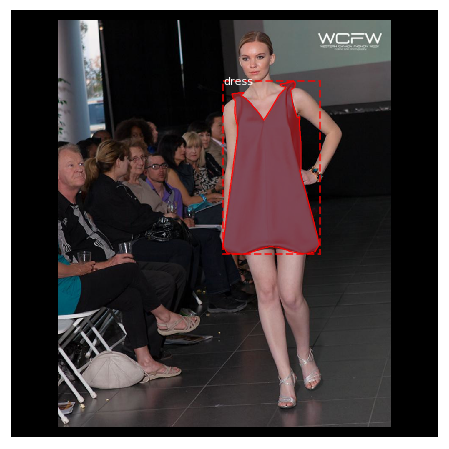

In [0]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


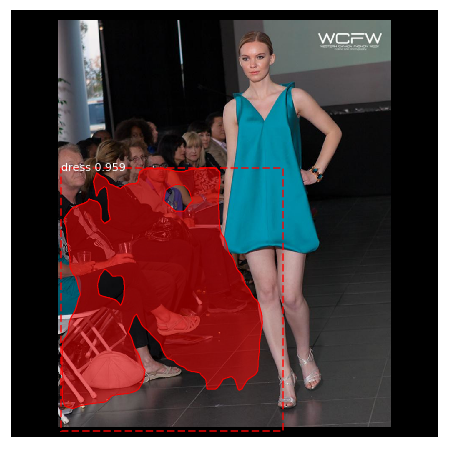

In [0]:
results = modelResnet50.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [0]:
modelResnet101.train(dataset_train, dataset_val, 
            learning_rate=configResnet101.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/Development/fashion_instance_segmentation/logs/dress20191116T1805/mask_rcnn_dress_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mas

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 1/10
100/100 [==============================] - 172s 2s/step - loss: 0.6941 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.3220 - mrcnn_mask_loss: 0.2666 - val_loss: 1.4372 - val_rpn_class_loss: 0.0126 - val_rpn_bbox_loss: 0.4313 - val_mrcnn_class_loss: 0.0279 - val_mrcnn_bbox_loss: 0.6767 - val_mrcnn_mask_loss: 0.2887
Epoch 2/10
100/100 [==============================] - 80s 798ms/step - loss: 0.1874 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.0997 - val_loss: 1.4297 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.4783 - val_mrcnn_class_loss: 0.0461 - val_mrcnn_bbox_loss: 0.6395 - val_mrcnn_mask_loss: 0.2557
Epoch 3/10
100/100 [==============================] - 82s 824ms/step - loss: 0.1642 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.0754 - val_loss: 1.3542 - val_rpn_cla

In [0]:

inference_config = dress.InferenceResnet101Config()

# Recreate the model in inference mode
modelResnet101 = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = modelResnet101.find_last()

# Load trained weights
print("Loading weights from ", model_path)
modelResnet101.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/Development/fashion_instance_segmentation/logs/dress20191116T1805/mask_rcnn_dress_0010.h5
Re-starting from epoch 10


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


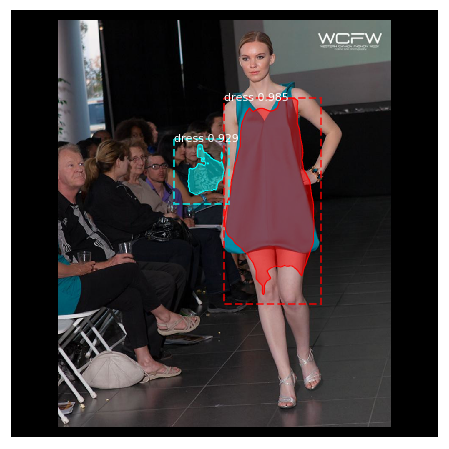

In [0]:
results = modelResnet101.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())